In [2]:
!git clone https://github.com/riskiilyas/Temperature-Prediction.git

Cloning into 'Temperature-Prediction'...
remote: Enumerating objects: 200, done.
remote: Total 200 (delta 0), reused 0 (delta 0), pack-reused 200 (from 1)
Receiving objects: 100% (200/200), 45.35 MiB | 38.13 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [11]:
!pwd
%cd Temperature-Prediction
!pwd

/content
/content/Temperature-Prediction
/content/Temperature-Prediction


In [3]:
#Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🌊 WATER TEMPERATURE PREDICTION - EXPLORATORY DATA ANALYSIS")
print("=" * 80)
print("📊 Analyzing image-based temperature prediction dataset")
print("🔬 Models: Ridge Regression, Random Forest, Gradient Boosting")
print("=" * 80)

🌊 WATER TEMPERATURE PREDICTION - EXPLORATORY DATA ANALYSIS
📊 Analyzing image-based temperature prediction dataset
🔬 Models: Ridge Regression, Random Forest, Gradient Boosting


In [12]:
# Cell 2: Data Loading and Initial Exploration
def load_temperature_data(temp_file="temperatures.txt", img_folder="imgs"):
    """Load temperature labels and corresponding images"""
    temperatures = {}
    image_files = []
    temp_values = []

    # Read temperature file
    with open(temp_file, 'r') as f:
        for line in f:
            if ',' in line:
                filename, temp = line.strip().split(', ')
                temp_float = float(temp)
                temperatures[filename] = temp_float

                # Check if image exists
                img_path = os.path.join(img_folder, filename)
                if os.path.exists(img_path):
                    image_files.append(filename)
                    temp_values.append(temp_float)
                else:
                    print(f"⚠️  Image not found: {filename}")

    return image_files, temp_values, temperatures

# Load the data
image_files, temp_values, temp_dict = load_temperature_data()

print(f"📂 Dataset Overview:")
print(f"   Total images: {len(image_files)}")
print(f"   Temperature range: {min(temp_values):.1f}°C - {max(temp_values):.1f}°C")
print(f"   Mean temperature: {np.mean(temp_values):.1f}°C")
print(f"   Standard deviation: {np.std(temp_values):.1f}°C")

⚠️  Image not found: IMG-20250705-WA0050.jpg
⚠️  Image not found: IMG-20250705-WA0054.jpg
📂 Dataset Overview:
   Total images: 135
   Temperature range: 16.8°C - 33.1°C
   Mean temperature: 27.1°C
   Standard deviation: 4.2°C


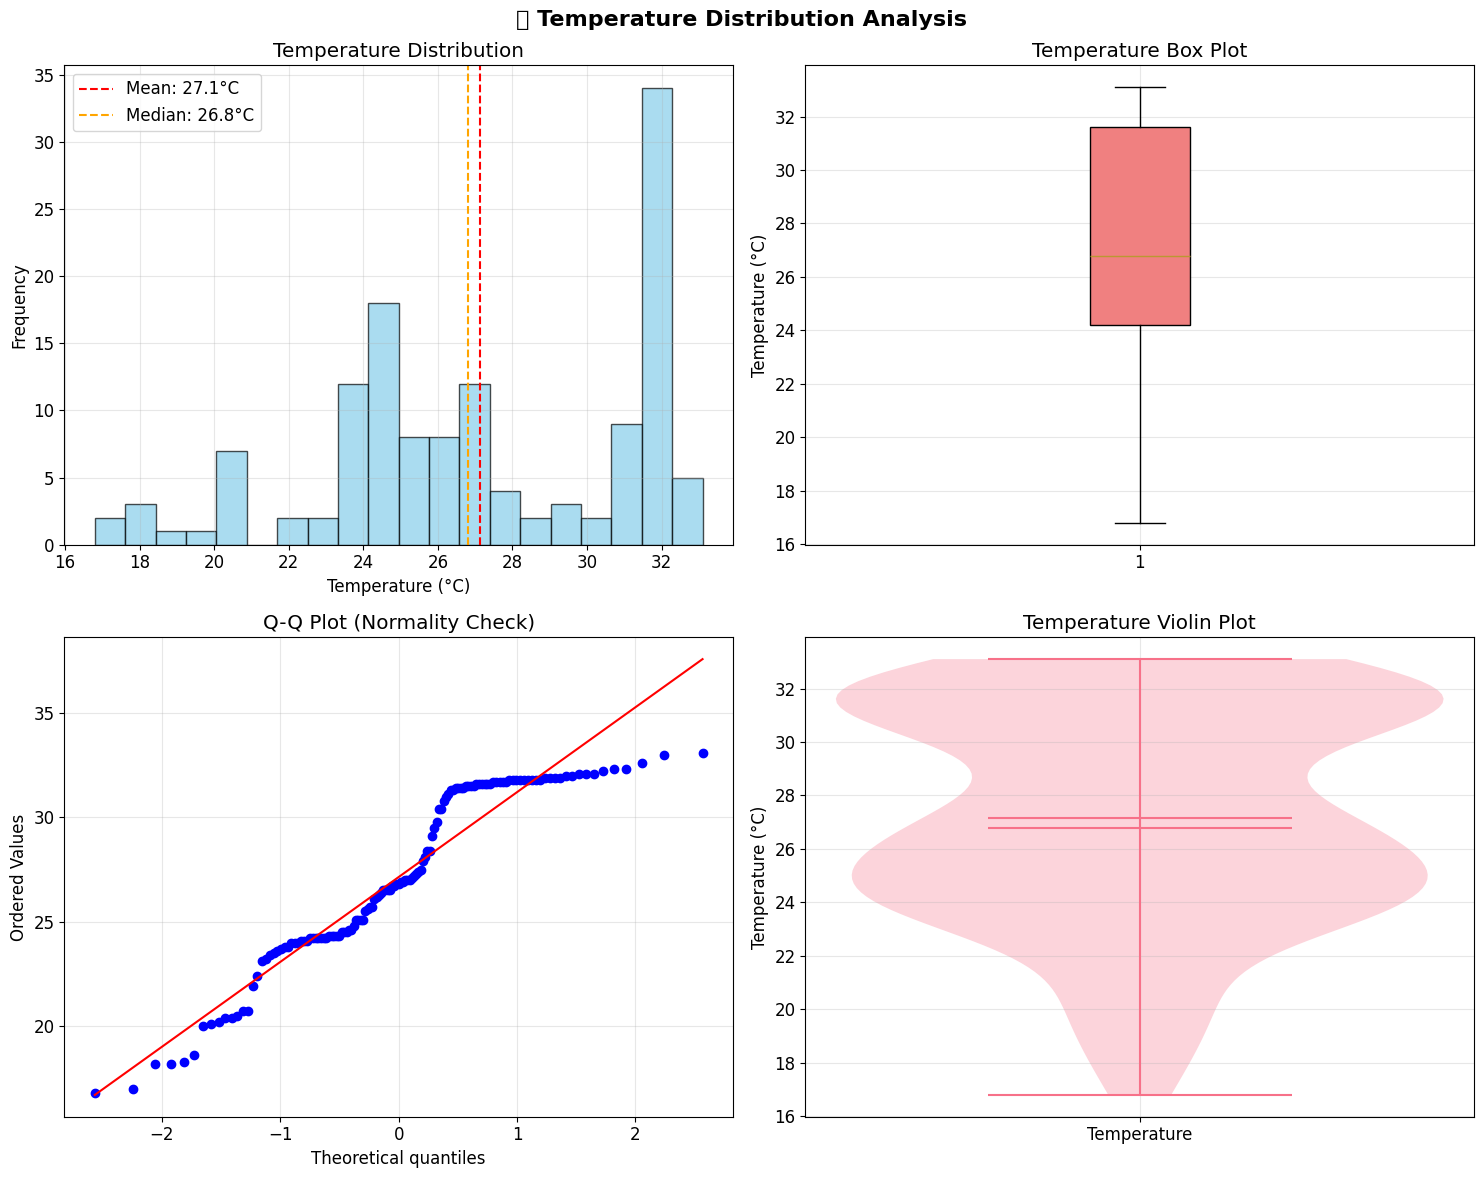


📈 Statistical Summary:
   Count: 135
   Mean: 27.14°C
   Median: 26.80°C
   Std Dev: 4.17°C
   Min: 16.80°C
   Max: 33.10°C
   Range: 16.30°C
   25th Percentile: 24.20°C
   75th Percentile: 31.60°C
   IQR: 7.40°C


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🌡️ Temperature Distribution Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0,0].hist(temp_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(np.mean(temp_values), color='red', linestyle='--',
                  label=f'Mean: {np.mean(temp_values):.1f}°C')
axes[0,0].axvline(np.median(temp_values), color='orange', linestyle='--',
                  label=f'Median: {np.median(temp_values):.1f}°C')
axes[0,0].set_xlabel('Temperature (°C)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Temperature Distribution')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Box plot
bp = axes[0,1].boxplot(temp_values, patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
axes[0,1].set_ylabel('Temperature (°C)')
axes[0,1].set_title('Temperature Box Plot')
axes[0,1].grid(alpha=0.3)

# Q-Q plot for normality check
from scipy import stats
stats.probplot(temp_values, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (Normality Check)')
axes[1,0].grid(alpha=0.3)

# Violin plot
axes[1,1].violinplot(temp_values, positions=[1], showmeans=True, showmedians=True)
axes[1,1].set_ylabel('Temperature (°C)')
axes[1,1].set_title('Temperature Violin Plot')
axes[1,1].set_xticks([1])
axes[1,1].set_xticklabels(['Temperature'])
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print(f"\n📈 Statistical Summary:")
print(f"   Count: {len(temp_values)}")
print(f"   Mean: {np.mean(temp_values):.2f}°C")
print(f"   Median: {np.median(temp_values):.2f}°C")
print(f"   Std Dev: {np.std(temp_values):.2f}°C")
print(f"   Min: {np.min(temp_values):.2f}°C")
print(f"   Max: {np.max(temp_values):.2f}°C")
print(f"   Range: {np.max(temp_values) - np.min(temp_values):.2f}°C")
print(f"   25th Percentile: {np.percentile(temp_values, 25):.2f}°C")
print(f"   75th Percentile: {np.percentile(temp_values, 75):.2f}°C")
print(f"   IQR: {np.percentile(temp_values, 75) - np.percentile(temp_values, 25):.2f}°C")


In [14]:
# Cell 4: Feature Extraction Functions
def extract_enhanced_features(image_path, patch_size=64):
    """Extract comprehensive features from water images"""
    image = cv2.imread(image_path)
    if image is None:
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image_rgb.shape[:2]

    features = []
    patch_info = []

    # Multiple patches (center, top, bottom, left, right)
    patches = extract_multiple_patches(image_rgb, patch_size)
    patch_names = ['center', 'top', 'bottom', 'left', 'right']

    for i, (patch, name) in enumerate(zip(patches, patch_names)):
        # RGB statistics
        rgb_mean = np.mean(patch, axis=(0, 1))
        rgb_std = np.std(patch, axis=(0, 1))
        rgb_max = np.max(patch, axis=(0, 1))
        rgb_min = np.min(patch, axis=(0, 1))

        features.extend(rgb_mean)      # 3 features
        features.extend(rgb_std)       # 3 features
        features.extend(rgb_max)       # 3 features
        features.extend(rgb_min)       # 3 features

        # HSV features
        patch_hsv = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)
        hsv_mean = np.mean(patch_hsv, axis=(0, 1))
        features.extend(hsv_mean)      # 3 features

        # Brightness and contrast
        gray_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
        brightness = np.mean(gray_patch)
        contrast = np.std(gray_patch)
        features.extend([brightness, contrast])  # 2 features

        # Store patch info for analysis
        patch_info.append({
            'name': name,
            'rgb_mean': rgb_mean,
            'hsv_mean': hsv_mean,
            'brightness': brightness,
            'contrast': contrast
        })

    return np.array(features), patch_info

def extract_multiple_patches(image_rgb, patch_size):
    """Extract patches from different positions"""
    height, width = image_rgb.shape[:2]
    half_patch = patch_size // 2

    patches = []

    # Define patch locations
    locations = [
        (width // 2, height // 2),      # Center
        (width // 2, height // 4),      # Top
        (width // 2, 3 * height // 4),  # Bottom
        (width // 4, height // 2),      # Left
        (3 * width // 4, height // 2),  # Right
    ]

    for center_x, center_y in locations:
        start_y = max(0, center_y - half_patch)
        end_y = min(height, center_y + half_patch)
        start_x = max(0, center_x - half_patch)
        end_x = min(width, center_x + half_patch)

        patch = image_rgb[start_y:end_y, start_x:end_x]

        # Resize if needed
        if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
            patch = cv2.resize(patch, (patch_size, patch_size))

        patches.append(patch)

    return patches


In [15]:
# Cell 5: Feature Extraction for All Images
print("🔧 Extracting features from all images...")
print("=" * 50)

features_list = []
valid_temperatures = []
valid_filenames = []
patch_analysis = []

for i, filename in enumerate(image_files):
    img_path = os.path.join("imgs", filename)

    try:
        features, patch_info = extract_enhanced_features(img_path)
        if features is not None:
            features_list.append(features)
            valid_temperatures.append(temp_dict[filename])
            valid_filenames.append(filename)
            patch_analysis.append(patch_info)

        if (i + 1) % 20 == 0:
            print(f"   Processed {i + 1}/{len(image_files)} images...")

    except Exception as e:
        print(f"   ⚠️  Error processing {filename}: {e}")

# Convert to arrays
X = np.array(features_list)
y = np.array(valid_temperatures)

print(f"\n✅ Feature extraction completed!")
print(f"   Valid samples: {len(X)}")
print(f"   Feature dimensions: {X.shape}")
print(f"   Total features per image: {X.shape[1]}")
print(f"   Features per patch: {X.shape[1] // 5}")

🔧 Extracting features from all images...
   Processed 20/135 images...
   Processed 40/135 images...
   Processed 60/135 images...
   Processed 80/135 images...
   Processed 100/135 images...
   Processed 120/135 images...

✅ Feature extraction completed!
   Valid samples: 135
   Feature dimensions: (135, 85)
   Total features per image: 85
   Features per patch: 17



🎨 RGB COLOR ANALYSIS


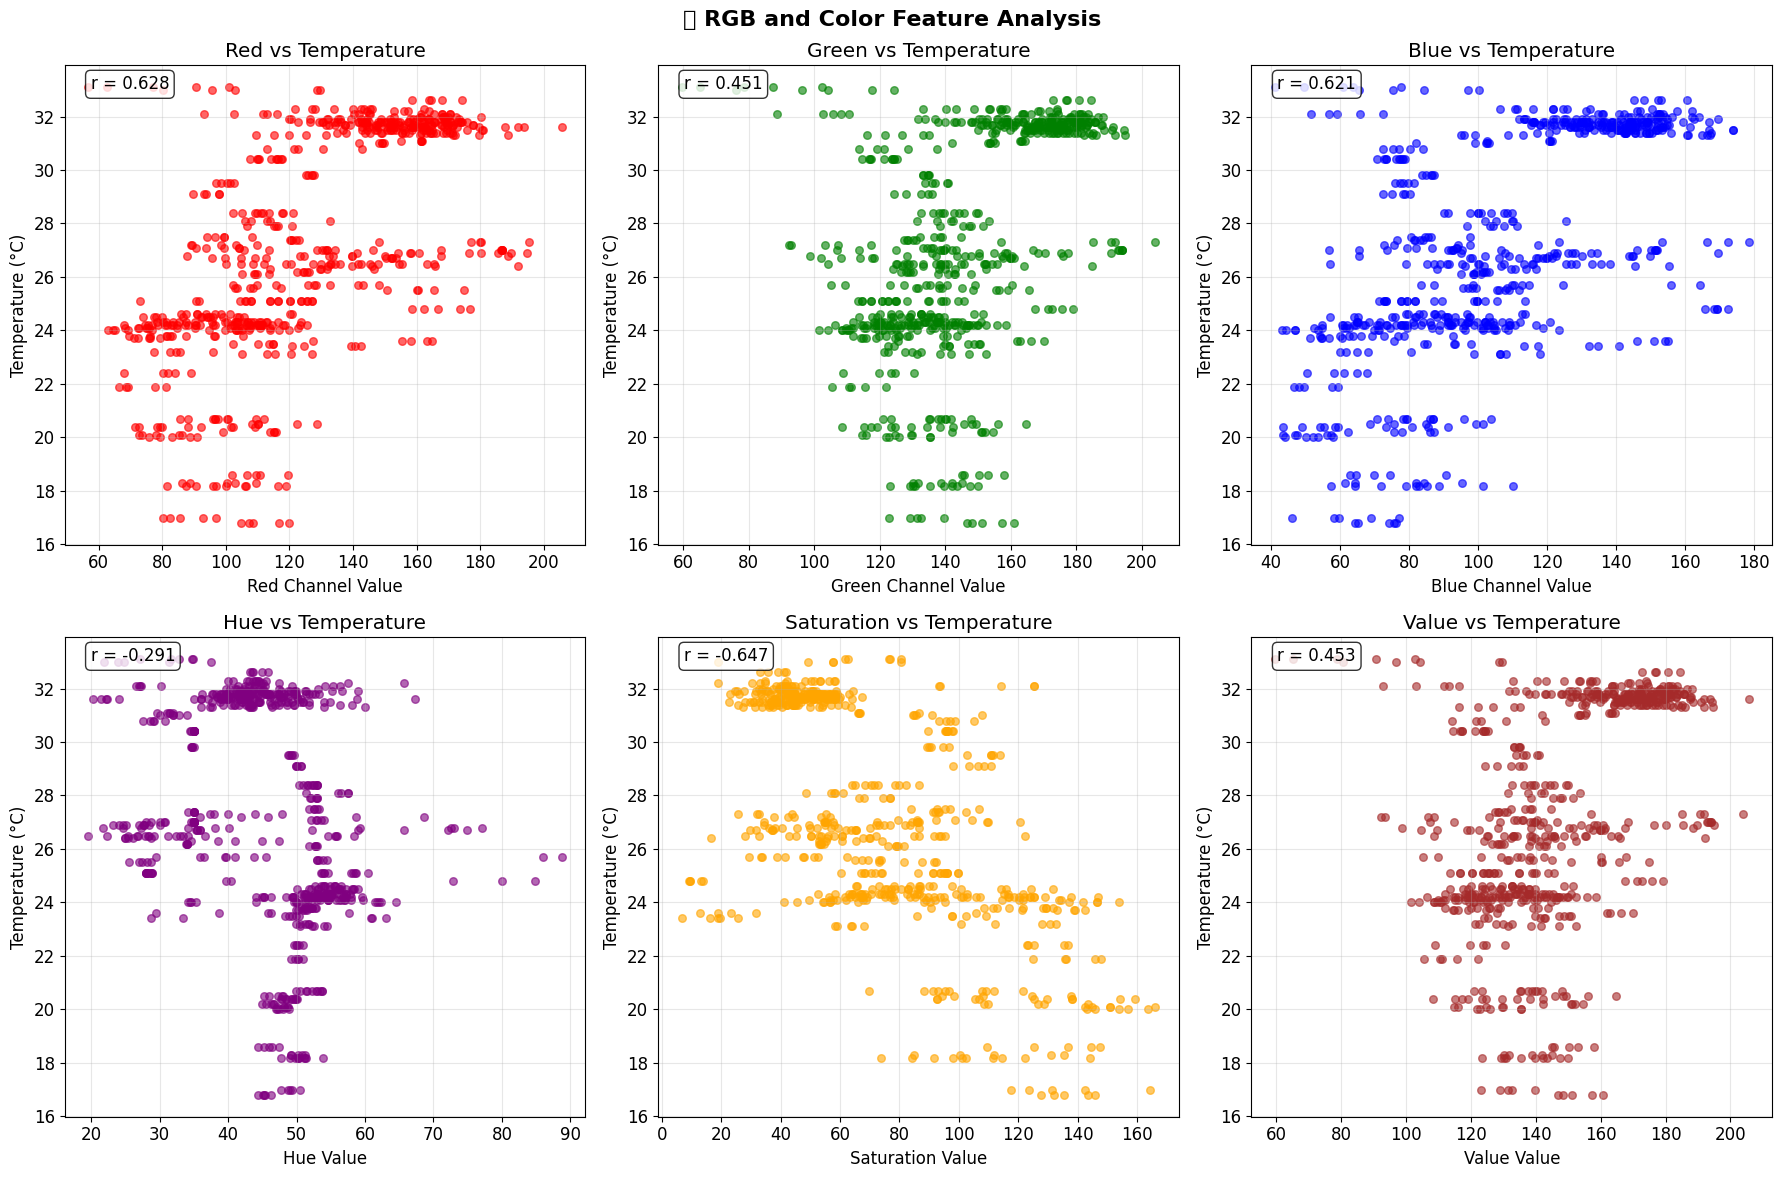

In [16]:

# Cell 6: RGB Color Analysis
print("\n🎨 RGB COLOR ANALYSIS")
print("=" * 50)

# Aggregate RGB statistics across all patches
rgb_data = []
for i, patch_info_list in enumerate(patch_analysis):
    temp = valid_temperatures[i]
    filename = valid_filenames[i]

    for patch_info in patch_info_list:
        rgb_data.append({
            'filename': filename,
            'temperature': temp,
            'patch': patch_info['name'],
            'red_mean': patch_info['rgb_mean'][0],
            'green_mean': patch_info['rgb_mean'][1],
            'blue_mean': patch_info['rgb_mean'][2],
            'hue_mean': patch_info['hsv_mean'][0],
            'saturation_mean': patch_info['hsv_mean'][1],
            'value_mean': patch_info['hsv_mean'][2],
            'brightness': patch_info['brightness'],
            'contrast': patch_info['contrast']
        })

rgb_df = pd.DataFrame(rgb_data)

# RGB analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🎨 RGB and Color Feature Analysis', fontsize=16, fontweight='bold')

# RGB vs Temperature scatter plots
colors = ['red', 'green', 'blue']
rgb_channels = ['red_mean', 'green_mean', 'blue_mean']

for i, (channel, color) in enumerate(zip(rgb_channels, colors)):
    axes[0, i].scatter(rgb_df[channel], rgb_df['temperature'],
                      alpha=0.6, color=color, s=30)
    axes[0, i].set_xlabel(f'{channel.split("_")[0].title()} Channel Value')
    axes[0, i].set_ylabel('Temperature (°C)')
    axes[0, i].set_title(f'{channel.split("_")[0].title()} vs Temperature')
    axes[0, i].grid(alpha=0.3)

    # Add correlation coefficient
    corr = rgb_df[channel].corr(rgb_df['temperature'])
    axes[0, i].text(0.05, 0.95, f'r = {corr:.3f}',
                   transform=axes[0, i].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# HSV analysis
hsv_channels = ['hue_mean', 'saturation_mean', 'value_mean']
hsv_colors = ['purple', 'orange', 'brown']

for i, (channel, color) in enumerate(zip(hsv_channels, hsv_colors)):
    axes[1, i].scatter(rgb_df[channel], rgb_df['temperature'],
                      alpha=0.6, color=color, s=30)
    axes[1, i].set_xlabel(f'{channel.split("_")[0].title()} Value')
    axes[1, i].set_ylabel('Temperature (°C)')
    axes[1, i].set_title(f'{channel.split("_")[0].title()} vs Temperature')
    axes[1, i].grid(alpha=0.3)

    # Add correlation coefficient
    corr = rgb_df[channel].corr(rgb_df['temperature'])
    axes[1, i].text(0.05, 0.95, f'r = {corr:.3f}',
                   transform=axes[1, i].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


📊 CORRELATION ANALYSIS


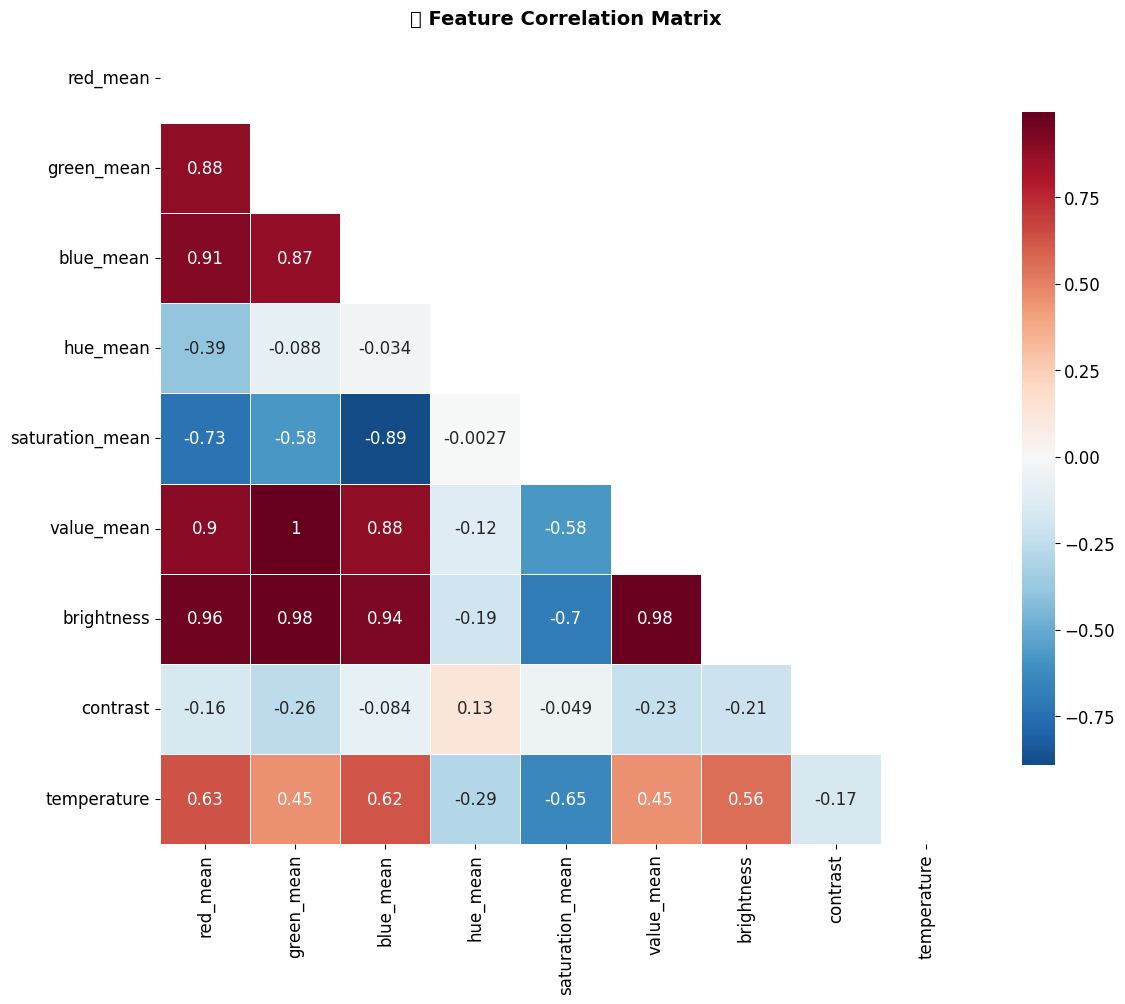

🔗 Features most correlated with temperature:
   saturation_mean     : 0.647
   red_mean            : 0.628
   blue_mean           : 0.621
   brightness          : 0.556
   value_mean          : 0.453
   green_mean          : 0.451
   hue_mean            : 0.291
   contrast            : 0.167


In [17]:
# Cell 7: Correlation Analysis
print("\n📊 CORRELATION ANALYSIS")
print("=" * 50)

# Calculate correlation matrix for key features
key_features = ['red_mean', 'green_mean', 'blue_mean', 'hue_mean',
               'saturation_mean', 'value_mean', 'brightness', 'contrast', 'temperature']

corr_matrix = rgb_df[key_features].corr()

# Correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('🔗 Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with temperature
temp_corr = corr_matrix['temperature'].abs().sort_values(ascending=False)
print("🔗 Features most correlated with temperature:")
for feature, corr in temp_corr.items():
    if feature != 'temperature':
        print(f"   {feature:<20}: {corr:.3f}")


📍 PATCH-WISE ANALYSIS
📊 Average values by patch location:
       red_mean         green_mean         blue_mean         brightness  \
           mean     std       mean     std      mean     std       mean   
patch                                                                     
bottom  121.322  30.340    141.161  23.711   102.632  30.778    130.855   
center  125.303  31.057    145.762  22.111   105.981  31.483    135.108   
left    124.970  33.161    143.637  24.894   106.319  32.062    133.795   
right   125.580  29.603    146.917  21.437   105.288  32.087    135.790   
top     130.523  32.822    149.539  24.458   110.594  34.680    139.397   

               contrast        temperature         
           std     mean    std        mean    std  
patch                                              
bottom  25.643    6.962  7.570      27.142  4.188  
center  24.876    7.324  7.146      27.142  4.188  
left    27.469    6.809  6.598      27.142  4.188  
right   23.920    6.392  6.6

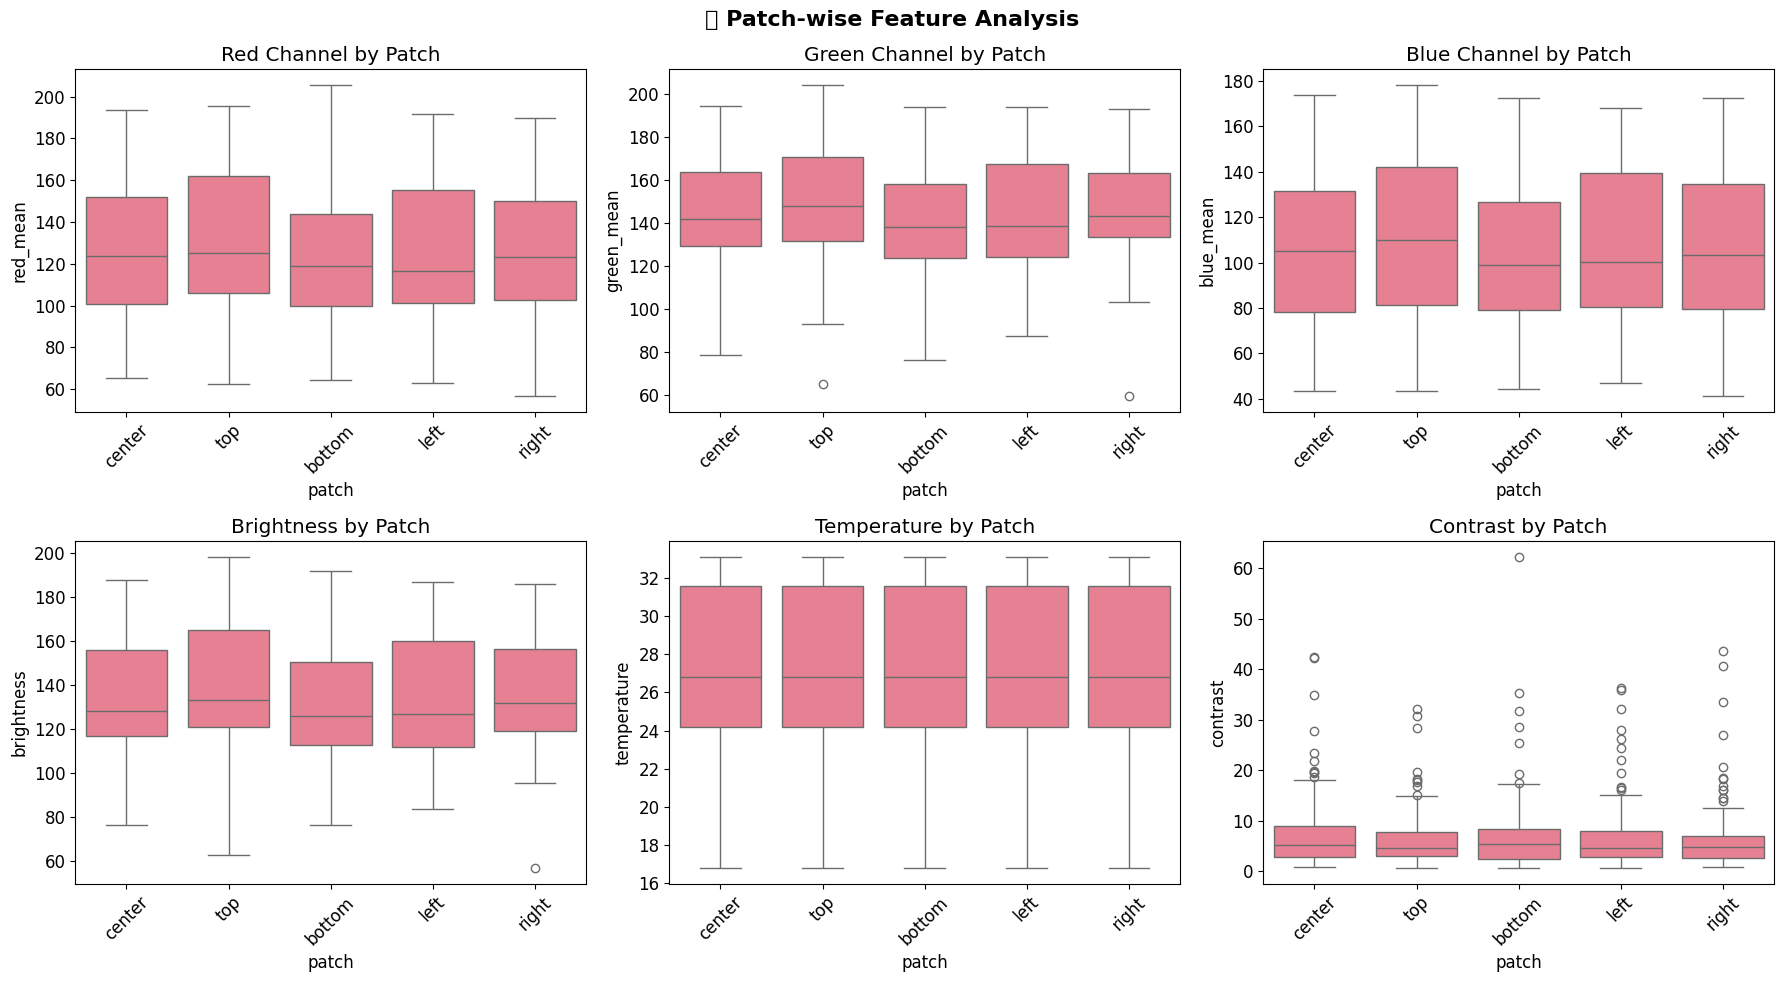

In [19]:
# Cell 8: Patch-wise Analysis (FIXED)
print("\n📍 PATCH-WISE ANALYSIS")
print("=" * 50)

# Analyze differences between patches
patch_stats = rgb_df.groupby('patch').agg({
    'red_mean': ['mean', 'std'],
    'green_mean': ['mean', 'std'],
    'blue_mean': ['mean', 'std'],
    'brightness': ['mean', 'std'],
    'contrast': ['mean', 'std'],
    'temperature': ['mean', 'std']
}).round(3)

print("📊 Average values by patch location:")
print(patch_stats)

# Patch comparison plots - FIXED LAYOUT
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Changed to 2x3 grid
fig.suptitle('📍 Patch-wise Feature Analysis', fontsize=16, fontweight='bold')

# Box plots for each RGB channel by patch
rgb_channels = ['red_mean', 'green_mean', 'blue_mean']
for i, channel in enumerate(rgb_channels):
    row, col = 0, i  # First row, columns 0, 1, 2
    sns.boxplot(data=rgb_df, x='patch', y=channel, ax=axes[row, col])
    axes[row, col].set_title(f'{channel.split("_")[0].title()} Channel by Patch')
    axes[row, col].tick_params(axis='x', rotation=45)

# Brightness comparison - Second row, first column
sns.boxplot(data=rgb_df, x='patch', y='brightness', ax=axes[1, 0])
axes[1, 0].set_title('Brightness by Patch')
axes[1, 0].tick_params(axis='x', rotation=45)

# Temperature by patch - Second row, second column
sns.boxplot(data=rgb_df, x='patch', y='temperature', ax=axes[1, 1])
axes[1, 1].set_title('Temperature by Patch')
axes[1, 1].tick_params(axis='x', rotation=45)

# Contrast by patch - Second row, third column
sns.boxplot(data=rgb_df, x='patch', y='contrast', ax=axes[1, 2])
axes[1, 2].set_title('Contrast by Patch')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


🎯 PRELIMINARY FEATURE IMPORTANCE


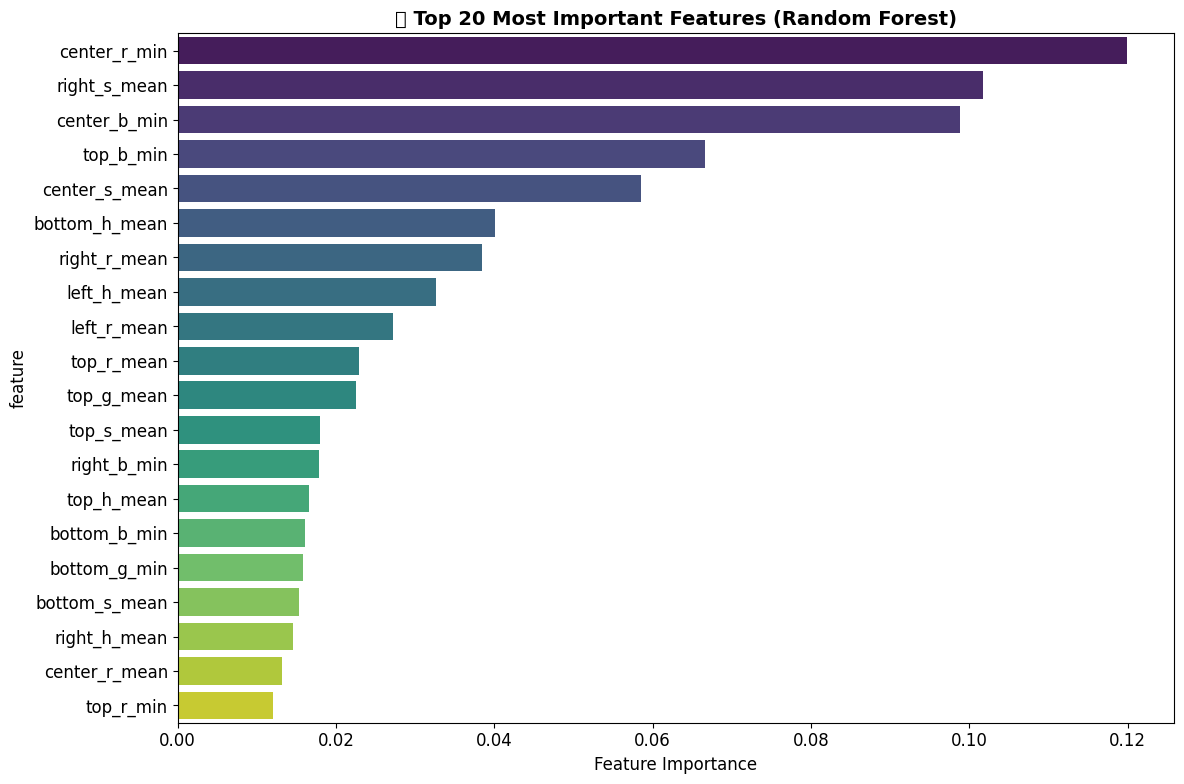

🏆 Top 10 most important features:
    1. center_r_min             : 0.1199
    2. right_s_mean             : 0.1017
    3. center_b_min             : 0.0988
    4. top_b_min                : 0.0666
    5. center_s_mean            : 0.0586
    6. bottom_h_mean            : 0.0401
    7. right_r_mean             : 0.0385
    8. left_h_mean              : 0.0326
    9. left_r_mean              : 0.0273
   10. top_r_mean               : 0.0230


In [20]:
# Cell 9: Feature Importance Analysis (Preliminary)
print("\n🎯 PRELIMINARY FEATURE IMPORTANCE")
print("=" * 50)

# Create feature names for better interpretation
feature_names = []
patch_names = ['center', 'top', 'bottom', 'left', 'right']
feature_types = ['r_mean', 'g_mean', 'b_mean', 'r_std', 'g_std', 'b_std',
                'r_max', 'g_max', 'b_max', 'r_min', 'g_min', 'b_min',
                'h_mean', 's_mean', 'v_mean', 'brightness', 'contrast']

for patch in patch_names:
    for feat_type in feature_types:
        feature_names.append(f"{patch}_{feat_type}")

# Quick Random Forest for feature importance
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X, y)

# Get feature importance
importance_scores = rf_temp.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('🎯 Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("🏆 Top 10 most important features:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['feature']:<25}: {row['importance']:.4f}")


In [21]:
# Cell 10: Data Quality Assessment
print("\n🔍 DATA QUALITY ASSESSMENT")
print("=" * 50)

# Check for outliers using IQR method
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = [(i, temp, filename) for i, (temp, filename) in enumerate(zip(y, valid_filenames))
            if temp < lower_bound or temp > upper_bound]

print(f"📊 Data Quality Metrics:")
print(f"   Total samples: {len(y)}")
print(f"   Missing values: 0 (handled during loading)")
print(f"   Outliers detected: {len(outliers)}")
print(f"   Temperature range: {np.min(y):.1f}°C - {np.max(y):.1f}°C")
print(f"   IQR bounds: {lower_bound:.1f}°C - {upper_bound:.1f}°C")

if outliers:
    print(f"\n🚨 Outlier samples:")
    for i, temp, filename in outliers:
        print(f"   {filename}: {temp:.1f}°C")

# Feature scaling analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n📏 Feature Scaling Statistics:")
print(f"   Original features mean range: {np.mean(X, axis=0).min():.3f} - {np.mean(X, axis=0).max():.3f}")
print(f"   Original features std range: {np.std(X, axis=0).min():.3f} - {np.std(X, axis=0).max():.3f}")
print(f"   Scaled features mean: ~{np.mean(X_scaled.mean()):.3f} (should be ~0)")
print(f"   Scaled features std: ~{np.mean(X_scaled.std()):.3f} (should be ~1)")



🔍 DATA QUALITY ASSESSMENT
📊 Data Quality Metrics:
   Total samples: 135
   Missing values: 0 (handled during loading)
   Outliers detected: 0
   Temperature range: 16.8°C - 33.1°C
   IQR bounds: 13.1°C - 42.7°C

📏 Feature Scaling Statistics:
   Original features mean range: 5.894 - 176.385
   Original features std range: 5.200 - 43.729
   Scaled features mean: ~-0.000 (should be ~0)
   Scaled features std: ~1.000 (should be ~1)


In [23]:
# Cell 11: Dataset Characteristics Summary
print("\n📋 DATASET CHARACTERISTICS SUMMARY")
print("=" * 80)

# Image type analysis
image_categories = []
for filename in valid_filenames:
    if filename.startswith('laut_'):
        image_categories.append('Sea/Ocean')
    elif filename.startswith('IMG_'):
        image_categories.append('General Water')
    else:
        image_categories.append('Mixed/Other')

category_counts = pd.Series(image_categories).value_counts()
print(f"📸 Image Categories:")
for category, count in category_counts.items():
    percentage = (count / len(image_categories)) * 100
    print(f"   {category:<15}: {count:3d} images ({percentage:5.1f}%)")

# Temperature distribution by category
if len(category_counts) > 1:
    category_df = pd.DataFrame({
        'filename': valid_filenames,
        'temperature': y,
        'category': image_categories
    })

    print(f"\n🌡️ Temperature by Category:")
    for category in category_counts.index:
        cat_temps = category_df[category_df['category'] == category]['temperature']
        print(f"   {category:<15}: {cat_temps.mean():5.1f}°C ± {cat_temps.std():4.1f}°C")

# Final summary
print(f"\n📊 ANALYSIS SUMMARY:")
print(f"   • Dataset size: {len(X)} samples")
print(f"   • Feature dimensions: {X.shape[1]} features per sample")
print(f"   • Temperature range: {np.min(y):.1f}°C - {np.max(y):.1f}°C")
print(f"   • Data quality: {'Good' if len(outliers) < len(y) * 0.1 else 'Needs attention'}")
print(f"   • Feature extraction: 5 patches × 17 features = 85 total features")
print(f"   • Ready for model training: ✅")

print("\n" + "=" * 80)
print("📝 EDA COMPLETE - Ready for Model Training!")
print("=" * 80)


📋 DATASET CHARACTERISTICS SUMMARY
📸 Image Categories:
   Mixed/Other    :  57 images ( 42.2%)
   Sea/Ocean      :  40 images ( 29.6%)
   General Water  :  38 images ( 28.1%)

🌡️ Temperature by Category:
   Mixed/Other    :  23.6°C ±  3.0°C
   Sea/Ocean      :  31.8°C ±  0.3°C
   General Water  :  27.6°C ±  2.6°C

📊 ANALYSIS SUMMARY:
   • Dataset size: 135 samples
   • Feature dimensions: 85 features per sample
   • Temperature range: 16.8°C - 33.1°C
   • Data quality: Good
   • Feature extraction: 5 patches × 17 features = 85 total features
   • Ready for model training: ✅

📝 EDA COMPLETE - Ready for Model Training!
